# Monte Carlo 2D Potts Model: Wolff Algorithm

NxN spins, B = 0, J = 1, k = 1, q states

In [1]:
from math import *
from random import *
import numpy as np
import matplotlib.pyplot as plt

Some basic conditions (to test functions & debugging):

In [2]:
N = 10 #length of ising model
I = np.ones((N,N)) #all spins starting in the same direction, periodic bounday conditions
T = 3 #final temp, near critical region
beta_0 = 1/T #make k = 1 here for simplicity
q = 5 #5 state potts model (so spins go from 1 to 5)
print(I)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [3]:
def kd(a,b): #kronecker delta
    if(a==b):
        return 1
    else: 
        return 0

Defining functions that calculate internal energy, flip a spin, and energy change when flipping a spin:

In [4]:
def E(ising_array): #gets energy in 2D ising array, must have more than 2 by 2 grid.
    total_E = 0
    for i in range(len(ising_array)):
        for j in range(len(ising_array)):
            total_E += -kd(ising_array[i, j],ising_array[(i + 1)%len(ising_array), j])
            total_E += -kd(ising_array[i, j],ising_array[i, (j + 1)%len(ising_array)]) #periodic sum
    return total_E

In [5]:
def M(ising_array): #gets magnetization in ising array
    total_M = 0
    for i in range(len(ising_array)):
        for j in range(len(ising_array)):
            total_M += ising_array[i,j]
    return total_M

In [6]:
def flip(ising_array, n, m, p): #just flips spin in position (n, m) to state p
    ising_array[n, m] = p  #updated array
    return 0

In [7]:
def flip_dE(ising_array, n, m, p): #energy change when flipping spin in position (n,m) to p
    E1 = 0
    E2 = 0
    
    E1 += -kd(ising_array[n, m],ising_array[(n + 1)%len(ising_array), m])
    E1 += -kd(ising_array[n, m],ising_array[(n - 1)%len(ising_array), m])
    E1 += -kd(ising_array[n, m],ising_array[n, (m + 1)%len(ising_array)])
    E1 += -kd(ising_array[n, m],ising_array[n, (m - 1)%len(ising_array)]) 
    
    E2 += -kd(p,ising_array[(n + 1)%len(ising_array), m])
    E2 += -kd(p,ising_array[(n - 1)%len(ising_array), m])
    E2 += -kd(p,ising_array[n, (m + 1)%len(ising_array)])
    E2 += -kd(p,ising_array[n, (m - 1)%len(ising_array)]) #dE = (energy after flip) - (energy before flip)
    
    dE = E2 - E1
    
    return dE

In [8]:
I = np.asarray([[2,2,3],[4,10,5],[2,2,7]])
print(I)
print(E(I))
print(flip_dE(I, 0, 2, 2))
flip(I, 0, 2, 2)
print(E(I))
print(I)

[[ 2  2  3]
 [ 4 10  5]
 [ 2  2  7]]
-4
-2
-6
[[ 2  2  2]
 [ 4 10  5]
 [ 2  2  7]]


In [9]:
def flip_dM(ising_array, n, m, p): #magnetization change when flipping a spin to p
    return p - ising_array[n, m]

In [10]:
def auto_correlation(m, t_max, t): #returns chi(t), needed to measure integrated correlation time
    sum1 = 0
    sum2 = 0
    sum3 = 0
    
    for i in range(t_max - t):
        #print(i+t)
        sum1 += m[i] * m[i + t]
        
        
    for i in range(t_max - t):
        sum2 += m[i]
        
    for i in range(t_max - t):
        sum3 += m[i + t]
        
    return sum1/(t_max - t) - sum2 * sum3 / (t_max - t)**2

In [11]:
def corr_time(chi_list):
    tau = 0
    
    for i in range(len(chi_list)):
        tau += chi_list[i]/chi_list[0]
    
    return tau

Using the above functions, we can apply the heat bath algorithm to N randomly
chosen spins (sweep):

In [12]:
def cycle(ising_array, beta, q): #does 1 sweep
    for k in range(len(ising_array) ** 2): 
        i = randint(0, len(ising_array) - 1)
        j = randint(0, len(ising_array) - 1) #random (i, j) spin is chosen
        
        s = randint(1,q)  
        
        while(s == ising_array[i,j]):
            s = randint(1,q)
        
        d_E = flip_dE(ising_array, i, j, s)
        
        if(d_E > 0):
            if(random() < np.exp(-beta*d_E)):
                flip(ising_array, i, j, s)
        else:
            flip(ising_array, i, j, s)
      
                
                
    return [E(I), M(I)]

Acceptance ratio plot for heat bath algorithm:

Running a simulation to equilibrium conditions takes around 1000 sweeps (possibly more for low T),
since the simulation is longer near the critical region (where the phase 
transition from ferromagnet to paramegnet occurs)

In [13]:
def simulation(ising_array, beta, q): #returns energy and magnetization
    E_list = []
    m_list = []
    for i in range(1000):
        E_element, M_element = cycle(I, beta, q)
        if(i > 200 && i%10 == 0):
            m_list.append(M_element/len(I))
            E_list.append(E_element)
                
    return [E_list, m_list]

In [14]:
I = np.ones((6,6))
I
a = simulation(I, 1/0.8, 2)
print(I)


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]


To get <q^2>, just convert q_array to numpy array and then np.average(q_array**2). 

In [15]:
def simple_error(q_array): #gets the error for simple averaged parameters like energy, magnetization
    q_array = np.asarray(q_array)
    sigma = np.sqrt((np.average(q_array**2) - np.average(q_array)**2)/len(q_array))
    return sigma

In [16]:
def specific_heat(e_l, beta, spin_num): #gets specific heat from energy list
    e_l = np.asarray(e_l)
    return ((beta**2)/spin_num) * (np.average(e_l**2) - np.average(e_l)**2)

In [17]:
def c_bootstrap(e_l, beta, spin_num): #bootstrap error method, used to calculate specific heat error from overall energy list 
    e_l = np.asarray(e_l)
    c_list = []
    for i in range(10): #do this process 10 times
        temp_list = []
        for j in range(len(e_l)):
            index = randint(0, len(e_l)-1)
            temp_list.append(e_l[index])
        c_list.append(specific_heat(temp_list, beta, spin_num))
        #print(c_list) #troubleshoot
    c_list = np.asarray(c_list)
    sigma = np.sqrt(np.average(c_list**2) - np.average(c_list)**2)
    return sigma
        
    

In [18]:
list1 = [1,2,3,4,5]
list1[-2:]

[4, 5]

Getting integrated correlation time: Correlation time time is low when not near critical temperature, but becomes very large near critical temperature.

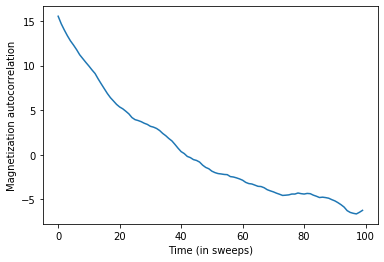

3.5069723932178345


In [19]:
b0 = 1/1
I = np.ones((5,5))

E_array = simulation(I, b0, 5)[0]
m_array = simulation(I, b0, 5)[1]

chi_array = []

for i in range(100): #get chi(0) to chi(300)
    chi_array.append(auto_correlation(m_array, 400, i))
    
t_array = np.arange(100)

plt.plot(t_array, chi_array)
plt.xlabel("Time (in sweeps)")
plt.ylabel("Magnetization autocorrelation")
plt.show()

print(corr_time(chi_array))

In [20]:
print(simple_error(E_array))
I
print(np.average(E_array))

0.18473070907404648
-27.3945


Computationally determined energies at a variety of temperatures:

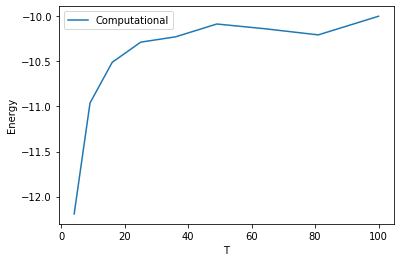

In [21]:
N = 5
T_array = np.asarray([4, 9, 16, 25, 36, 49, 64, 81, 100])
beta_array = 1/T_array #k = 1

E_comp = []

for i in range(len(T_array)):
    I = np.ones((N,N))
    E_comp.append(np.average(simulation(I, 1/T_array[i], 5)[0]))
    
plt.plot(T_array, E_comp, label="Computational")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.show()


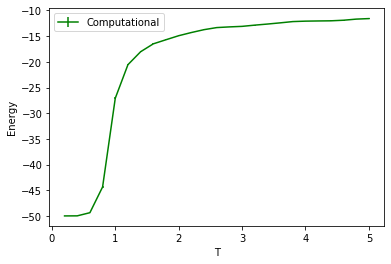

In [22]:
N = 5
T_array2 = np.linspace(0.2, 5, 25)
E_comp = []
E_error = []

for i in range(len(T_array2)):
    I = np.ones((N, N))
    energy_list = simulation(I, 1/T_array2[i], 5)[0]
    E_comp.append(np.average(energy_list))
    E_error.append(simple_error(energy_list))
    
    

plt.errorbar(T_array2, E_comp, yerr = E_error, label="Computational", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.show()

Calculating magnetization:

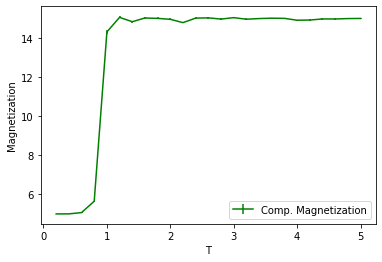

In [24]:
N = 5
T_array2 = np.linspace(0.2, 5, 25)
m_comp = []
m_error = []

for i in range(len(T_array2)):
    I = np.ones((N, N))
    m_list = simulation(I, 1/T_array2[i], 5)[1]
    m_comp.append(np.average(m_list))
    m_error.append(simple_error(m_list))

plt.errorbar(T_array2, m_comp, yerr = m_error, label="Comp. Magnetization", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Magnetization")
plt.show()


Calculating specific heat:

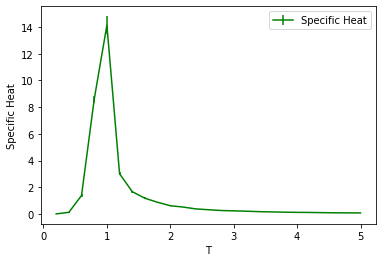

In [26]:
N = 5
T_array2 = np.linspace(0.2, 5, 25)
beta_array = 1/T_array2
c_comp = []
c_error = []

for i in range(len(T_array2)):
    I = np.ones((N, N))
    energy_list = simulation(I, 1/T_array2[i], 5)[0]
    c_comp.append(specific_heat(energy_list, beta_array[i], len(I)))
    c_error.append(c_bootstrap(energy_list, beta_array[i], len(I)))
    
    
plt.errorbar(T_array2, c_comp, yerr = c_error, label="Specific Heat", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.show()